# Solvent Box generation of non-standard solvent and non-standard solutes by means of OpenForceField 

Dependencies:
- openbabel 
- openmoltools (a.t.m. packmol.py should be adjusted)
- openforcefield
- mdtraj
- nglview

In [ ]:
#Modules to import

from sys import stdout
import time
import requests
from openbabel import openbabel,pybel
from simtk.openmm import app
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from openforcefield.topology import Molecule, Topology
from openforcefield.utils.toolkits import OpenEyeToolkitWrapper
from openforcefield.typing.engines.smirnoff import ForceField
from openmmforcefields.generators import SystemGenerator
from openmmforcefields.generators import SMIRNOFFTemplateGenerator
from openmoltools import packmol
import numpy as np
import nglview
import ipywidgets
import mdtraj as md
import parmed as pmd
import matplotlib.pyplot as plt
import pandas as pd

## Parameterizing all compounds with the openFF forcefield

### Create input files

In [1]:
#Create force field parameter files for small molecule
#Pubchem id for DBU is 81184, alphaCC1 78175, DMSO 679 (dimethylsulfoxide),DMF 6228, benzylalcohol 244 (benzylthiol 7509)
#Provide all Pubchem cids for the compounds which should be added
solutes = ["81184","78175","244"]
solvents = ["679"]

#generate sdf files and transform them to pdb using openbabel
obConversion = openbabel.OBConversion()
obConversion.SetInAndOutFormats("sdf", "pdb")
mol = openbabel.OBMol()
# TODO: Can we add residue names, instead of a cumbursome conversion process in which residue names are added

for cid in solutes+solvents:
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/CID/{cid}/record/SDF/?record_type=3d&response_type=save"
    with open(f"CID_{cid}.sdf", "w") as f:
        f.write(requests.get(url).text)
    obConversion.ReadFile(mol, f"CID_{cid}.sdf")
    obConversion.WriteFile(mol, f"CID_{cid}.pdb")



### Forcefield and simulation settings

Due to conflicting packages (openforcefield Forcefield and OpenMM Forcefield), we already define the forcefield here in the case of the openFF.

In [10]:
from openforcefield.utils import *
from openforcefield.topology import *
from openforcefield.utils.toolkits import OpenEyeToolkitWrapper
from openforcefield.typing.engines.smirnoff import ForceField

#Provide forcefield settings
solutes = ["81184","78175","244"]
solvents = ["679"]
##Forcefield
off_forcefield = ForceField('openff-1.0.0.offxml')
#Simulation settings
temperature = 298.15 #in K 
pressure = 1 #in bar, for an isobaric simulation
timestep = 2 #in femtoseconds
total_simulation_steps = 500000 

## Solvent box Setup

### Assessment of the Parsley forcefield to describe the organic solvent

#### Creating the solvent box

In [8]:
from openmoltools import packmol
import mdtraj as md
import openforcefield as off

#settings for solvent box
solvent_box_name = 'pure_DMSO_solvent_box'
number_of_solvent_molecules = 100
solvent_smiles= Molecule.from_file(f"CID_{solvents[0]}.pdb").to_smiles()
#number of molecules for each solute and solvent species in the order of the solutes and solvents provided before
n_molecules = [number_of_solvent_molecules]
if len(n_molecules)!= len(solvents): raise ValueError('Ascribe a number of molecules for each species') 
if OpenEyeToolkitWrapper.is_available():
    box_size = packmol.approximate_volume_by_density([solvent_smiles],n_molecules)
else:
    box_size = 20.0

print(f"The resulting starting box size for the system is :{box_size}")
pdb_filenames = [f"CID_{cid}.pdb" for cid in solvents]

# create box with corresponding md_traj trajectory and topology
md_traj_trajectory = packmol.pack_box(pdb_filenames,n_molecules,box_size=box_size)
print(md_traj_trajectory.topology)
md_traj_trajectory.save_pdb(f'{solvent_box_name}_N{number_of_solvent_molecules}_openmoltools.pdb')

The resulting starting box size for the system is :25.847666493454238

# Mixture 

tolerance 2.000000
filetype pdb
output /tmp/tmppso9e6zb/tmpf69u2i0d.pdb
add_amber_ter


structure CID_679.pdb
  number 100 
  inside box 0. 0. 0. 23.847666 23.847666 23.847666
end structure

<mdtraj.Topology with 100 chains, 100 residues, 1000 atoms, 900 bonds>


#### Creating the force field for the pure solvent box

In [9]:
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *


#Define all monomers (sdf,smiles or mol format) used in the solvent box, 
#(if a licence for openEye is obtained this can also be other formats are applicable)
monomer_names = [f"CID_{cid}.sdf" for cid in solvents]
pdb_solvent_box = PDBFile(f'{solvent_box_name}_N{number_of_solvent_molecules}_openmoltools.pdb')
unique_molecules = [Molecule.from_file(name) for name in monomer_names]

#omm_topology = pdb_box.getTopology()
pure_solvent_box_positions = pdb_solvent_box.getPositions()
off_solvent_box_topology = off.topology.Topology.from_openmm(pdb_solvent_box.topology, unique_molecules=unique_molecules)
off_solvent_box_system = off_forcefield.create_openmm_system(off_solvent_box_topology)

#### Equilibrate the solvent box until the volume is converged

In [11]:
from sys import stdout
import time

#Thermostat
integrator = LangevinIntegrator(temperature*kelvin, 1/picosecond, timestep*femtoseconds)
#for isobaric simulation
off_solvent_box_system.addForce(MonteCarloBarostat(pressure*bar, temperature*kelvin))  

#setting up the simulation
simulation = Simulation(pdb_solvent_box.topology, off_solvent_box_system, integrator)
simulation.context.setPositions(pure_solvent_box_positions)
simulation.minimizeEnergy()


with open(f"initial_{solvent_box_name}_N{number_of_solvent_molecules}.pdb", "w") as f:
    PDBFile.writeFile(simulation.topology, pure_solvent_box_positions, f)
    
simulation.reporters = []
simulation.reporters.append(DCDReporter(f'traj_{solvent_box_name}_N{number_of_solvent_molecules}.dcd', 100))
simulation.reporters.append(StateDataReporter(stdout, 10000, step=True,
                                              temperature=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter(f"scalars_{solvent_box_name}_N{number_of_solvent_molecules}.csv", 100, time=True,
                                              potentialEnergy=True, totalEnergy=True, temperature=True,volume=True,density=True))

print("Starting simulation")
start = time.process_time()

simulation.step(total_simulation_steps)

end = time.process_time()
print("Elapsed time %.2f seconds" % (end-start))
print("Done!")

Starting simulation
#"Step","Temperature (K)","Elapsed Time (s)"
10000,304.27087995776185,0.0001010894775390625
20000,299.1724362505004,25.451409578323364
30000,289.92815988424513,51.237693071365356
40000,292.00515828795346,76.81798028945923
50000,306.8623433274178,98.52464556694031
60000,298.3762483375655,120.76649951934814
70000,294.41576960016033,142.6169753074646
80000,296.8368577430987,164.25468945503235
90000,308.0663353942859,186.77651834487915
100000,289.76003990902973,208.96139216423035


KeyboardInterrupt: 

#### Check whether the simulated density matches the calculated one

##### Density $\rho$

The experimental saturated liquid density of acetonitril at 293.15K: 1.100 g/ml
The average density at convergion is: 1.0829331288815984
The absolute difference between obtained and experimental density is (remark the T difference):0.01706687111840166


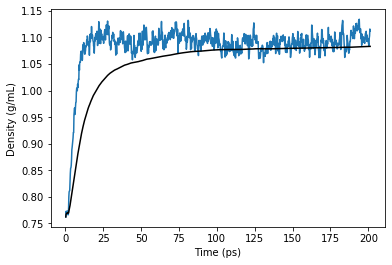

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = pd.read_csv(f'scalars_{solvent_box_name}_N{number_of_solvent_molecules}.csv')
time = data['#"Time (ps)"']
V = data["Box Volume (nm^3)"]
rho = data["Density (g/mL)"]
plt.plot(time,rho)
plt.xlabel('Time (ps)')
plt.ylabel('Density (g/mL)')

total_value = 0
ma_data=[]
for idx,value in enumerate(rho):
    total_value += value
    ma_data.append(total_value/(idx+1))

ma_data = np.array(ma_data)
plt.plot(time,ma_data,'black')

#http://ddbonline.ddbst.de/DIPPR105DensityCalculation/DIPPR105CalculationCGI.exe?component=Acetonitrile
#obtain via cid??? search tool?
print("The experimental saturated liquid density of acetonitril at 293.15K: 1.100 g/ml")
print(f"The average density at convergion is: {ma_data[-1]}")
print(f"The absolute difference between obtained and experimental density is (remark the T difference):{abs(ma_data[-1]-1.1)}")
plt.show()


##### Volume **V**

The average volume at convergion is: 12.010390359061246
The box dimensions for a NVT simulation should hence be: 22.90089071817561


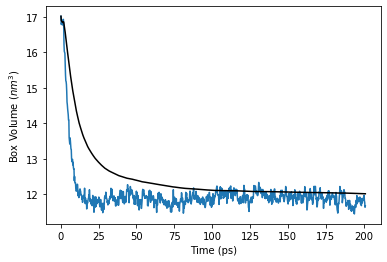

In [14]:
plt.plot(time,V)
plt.xlabel('Time (ps)')
plt.ylabel('Box Volume ($nm^3$)')
total_value = 0
ma_data=[]
for idx,value in enumerate(V):
    total_value += value
    ma_data.append(total_value/(idx+1))

ma_data = np.array(ma_data)
plt.plot(time,ma_data,'black')
print(f"The average volume at convergion is: {ma_data[-1]}")
cube_dim = ((ma_data[-1]**(1/3))*nanometer/angstrom)
print(f"The box dimensions for a NVT simulation should hence be: {cube_dim}")
plt.show()
plt.show()

### Creating a box with solvated solute(s)

####  Determining the number of solvent molecules (upper bound)

At the moment this volume is calculated with some manual input extracted a coordinate file manipulated with the program of choice. Ideally, in the future, this is automated. Here the calculated number of molecules is an upper bound as we do not account for the volume of the solutes itselves. This is easily done with Gaussian using the Volume keyword.

In [17]:
from molmod.units import *
from molmod.constants import *
import numpy as np

rho_exp = 1.1*gram/(centimeter**3)
MM= 78.14*gram #Molecular weight

##Determine initial box dimensions
#The number of solvent layers, can be determined using rdfs, or just use one in case only short range interactions are important and no proton-hopping mechanisms occur
number_of_solvent_layers = 1
Length_solutes =[6.3,7.0,5.5]
Length_solvent =[4.5]
Margin = [2.0] #this could be interesting to allow for through-space interactions occuring with the solvent which prevent close proximities
#2 options, on one hand you can allow for all solutes to be able to diffuse away from each other and get surrounded
# by a number of solvent layers (option 1); secondly one can make sure the total complex is surrounded with n solvent layers
# this latter option (option2) allows one to prevent far diffusion of the solutes and hence model reactivity?

option = 2

#If the solvent is a mixture one could calculate an alternative length? or take max length ?

Max_length = 0

if option==1:
    for length in Length_solutes:
        Max_length += number_of_solvent_layers*2*(Length_solvent[0]+Margin[0]) + length  
elif option==2:
    Max_length += number_of_solvent_layers*(Length_solvent[0]+Margin[0])*2 + sum(Length_solutes)
Total_length = np.sqrt((Max_length**2)/3)

Volume = (Total_length*angstrom)**3   #in bohr³
#Determine the number of solvent molecules
#1L ~= 1dm³ , approx
n_solvent_mol = int((rho_exp * Volume / MM) *avogadro)
print(f'The number of solvent molecules is:{n_solvent_mol}')



The number of solvent molecules is:52


#### Set box settings

In [23]:
#settings for solvent box
n_solvent_mol=60
sb_name = f'dbu_benzylaclohol_aCC_{len(solutes)}solutes_N{n_solvent_mol}solvent_box'


#number of molecules for each solute and solvent species in the order of the solutes and solvents provided before
n_molecules = [1,1,1,n_solvent_mol]
if len(n_molecules)!= len(solutes)+len(solvents): raise ValueError('Ascribe a number of molecules for each species') 

###  Using openmoltools (https://github.com/choderalab/openmoltools)

I have manually adjusted the packmol.py file (in ~/anaconda3/envs/openmm/lib/python3.7/site-packages/openmoltools) as the bonds were defined as an array of 1 x 4 
but in this case the bond type and order should be in the 3rd and fourth column, this is however not the case.
there for this is put to zero at the end which corresponds to a bond order and type of None, though antechambers
will put this correct normally based on the bonds. Alternatively n_atoms is added after each molecule 
to bonds_i [0] and [1] instead to avoid a potential loss of information.
'''
    #cast atom type and order to 0
    if len(bonds[0])==4:
        for idx,frame in enumerate(bonds):
               bonds[idx][2] = 0
               bonds[idx][3] = 0

TODO: Report to openmoltools

In [24]:
from openmoltools import packmol
import mdtraj as md

pdb_filenames = [f"CID_{cid}.pdb" for cid in solutes+solvents]
print(pdb_filenames)
print(n_molecules)
smiles_codes = [Molecule.from_file(f"CID_{cid}.pdb").to_smiles() for cid in solutes+solvents]
if OpenEyeToolkitWrapper.is_available():
    box_size = packmol.approximate_volume_by_density(smiles_codes,n_molecules)
else:
    box_size = Total_length


# create box with corresponding md_traj trajectory and topology
md_traj_trajectory = packmol.pack_box(pdb_filenames,n_molecules,box_size=box_size)
print(md_traj_trajectory.topology)
md_traj_trajectory.save_pdb(f'{sb_name}_openmoltools.pdb')


['CID_81184.pdb', 'CID_78175.pdb', 'CID_244.pdb', 'CID_679.pdb']
[1, 1, 1, 60]

# Mixture 

tolerance 2.000000
filetype pdb
output /tmp/tmpjc2q9oa9/tmp5x9ypqcm.pdb
add_amber_ter


structure CID_81184.pdb
  number 1 
  inside box 0. 0. 0. 20.387075 20.387075 20.387075
end structure

structure CID_78175.pdb
  number 1 
  inside box 0. 0. 0. 20.387075 20.387075 20.387075
end structure

structure CID_244.pdb
  number 1 
  inside box 0. 0. 0. 20.387075 20.387075 20.387075
end structure

structure CID_679.pdb
  number 60 
  inside box 0. 0. 0. 20.387075 20.387075 20.387075
end structure

<mdtraj.Topology with 63 chains, 63 residues, 660 atoms, 601 bonds>


### Visualize the created solvent box

In [25]:
import nglview
import ipywidgets

nglview.show_file(f"{sb_name}_openmoltools.pdb")

NGLWidget()

##  Generate a forcefield for the solvent box

In [26]:
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *


#Define all monomers (sdf,smiles or mol format) used in the solvent box, 
#(if a licence for openEye is obtained this can also be other formats are applicable)
monomer_names = [f"CID_{cid}.sdf" for cid in solutes+solvents]
pdb_box = PDBFile(f"{sb_name}_openmoltools.pdb")
unique_molecules = [Molecule.from_file(name) for name in monomer_names]

#omm_topology = pdb_box.getTopology()
box_positions = pdb_box.getPositions()
off_box_topology = off.topology.Topology.from_openmm(pdb_box.topology, unique_molecules=unique_molecules)
#if Total_length/2*angstrom > 1*nanometer:
off_box_system = off_forcefield.create_openmm_system(off_box_topology)
#off_box_system.setNonbondedMethod(PME)
#else:
    #off_box_system.setCutoffDistance(Total_length/2*angstrom)
    #off_box_system = off_forcefield.create_openmm_system(off_box_topology,nonbondedMethod=PME,nonbondedCutoff=Total_length/2*angstrom)
    #off_box_system.setNonbondedMethod(PME)



/home/elias/anaconda3/envs/openmm/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (ATOM      2  N   UNL A   1      19.182   3.193   2.793  1.00  0.00           N  , ATOM      1  N   UNL A   1      16.998   4.008   3.373  1.00  0.00           N  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/elias/anaconda3/envs/openmm/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (ATOM      4  C   UNL A   1      14.808   2.982   2.918  1.00  0.00           C  , ATOM      3  C   UNL A   1      15.665   3.754   3.917  1.00  0.00           C  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/elias/anaconda3/envs/openmm/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstr

## Performing an energy calculations

In [27]:
import numpy as np

integrator = VerletIntegrator(1.0 * femtoseconds)
context = Context(off_box_system, integrator)
context.setPositions(box_positions)
state = context.getState(getEnergy=True)
energy = state.getPotentialEnergy().in_units_of(kilojoules_per_mole)


print(f"Original energy: {energy}")

Original energy: 4119.146431633273 kJ/mol


## Performing a molecular dynamics simulations for the new compound

In [28]:
from sys import stdout
import time

#Thermostat
integrator = LangevinIntegrator(temperature*kelvin, 1/picosecond, timestep*femtoseconds)
#for isobaric simulation
off_box_system.addForce(MonteCarloBarostat(pressure*bar, temperature*kelvin))  

#setting up the simulation
simulation = Simulation(pdb_box.topology, off_box_system, integrator)
simulation.context.setPositions(box_positions)
simulation.minimizeEnergy()


with open(f"initial_{len(solutes)}solutes_N{n_solvent_mol}solvent_box.pdb", "w") as f:
    PDBFile.writeFile(simulation.topology, pdb_box.positions, f)
    
simulation.reporters = []
simulation.reporters.append(DCDReporter(f'traj_{len(solutes)}solutes_N{n_solvent_mol}solvent.dcd', 100))
simulation.reporters.append(StateDataReporter(stdout, 10000, step=True,
                                              temperature=True,volume=True, density=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter(f"scalars_{len(solutes)}solutes_N{n_solvent_mol}solvent.csv", 100, time=True,
                                              potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, density=True))

simulation.reporters.append(CheckpointReporter('checkpnt.chk', 50000))
print("Starting simulation")
start = time.process_time()

simulation.step(total_simulation_steps)

end = time.process_time()
print("Elapsed time %.2f seconds" % (end-start))
print("Done!")

simulation.saveCheckpoint('final_state.chk')
simulation.saveState('final_state_output.xml')


Starting simulation
#"Step","Temperature (K)","Box Volume (nm^3)","Density (g/mL)","Elapsed Time (s)"
10000,305.72445662256644,7.872396419032564,1.0708064730723317,0.00018477439880371094
20000,292.7192270497943,7.835109987899148,1.0759023239125998,14.850293636322021
30000,278.9520997249951,7.560965977264388,1.11491217781428,29.1780424118042
40000,292.5086005696688,7.898662081504868,1.067245687574148,43.460121393203735
50000,300.8814799134637,7.840267345147493,1.0751945913309837,57.60383176803589
60000,268.31544091877277,7.7337771537611815,1.0899994758695406,74.89332175254822
70000,293.6201514004132,7.501175318044816,1.1237989630521992,90.27532124519348
80000,297.041091386421,7.997312428009884,1.05408074524722,104.89367341995239
90000,284.91732861394394,7.861142794645475,1.0723393868170648,119.7385241985321
100000,292.78521406425756,7.677922199418891,1.097928948111708,134.51955795288086
110000,304.724768515992,7.948442444088499,1.0605616261788529,149.42782139778137
120000,288.4154416621

In [33]:
simulation.saveCheckpoint('final_state.chk')
simulation.saveState('final_state_output.xml')

## Visualize the output

In [29]:
traj = md.load(f'traj_{len(solutes)}solutes_N{n_solvent_mol}solvent.dcd', top=f"initial_{len(solutes)}solutes_N{n_solvent_mol}solvent_box.pdb")
traj.superpose(traj, 0)
nglview.show_mdtraj(traj)

NGLWidget(count=5000)

## Post-Processing

The average density at convergion is: 1.0883083983130308


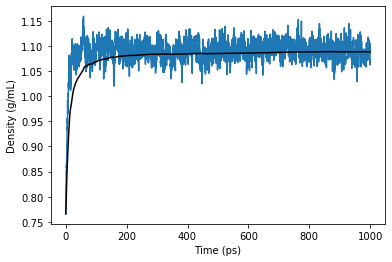

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv(f"scalars_{len(solutes)}solutes_N{n_solvent_mol}solvent.csv")
#print(data.head())
time = data['#"Time (ps)"']
V = data["Box Volume (nm^3)"]
rho = data["Density (g/mL)"]
plt.plot(time,rho)
plt.xlabel('Time (ps)')
plt.ylabel('Density (g/mL)')

total_value = 0
ma_data=[]
for idx,value in enumerate(rho):
    total_value += value
    ma_data.append(total_value/(idx+1))

ma_data = np.array(ma_data)
plt.plot(time,ma_data,'black')

#http://ddbonline.ddbst.de/DIPPR105DensityCalculation/DIPPR105CalculationCGI.exe?component=Acetonitrile
print(f"The average density at convergion is: {ma_data[-1]}")

plt.show()

The average volume at convergion is: 7.750486147487289
The box dimensions for a NVT simulation should hence be: 19.789871828795555


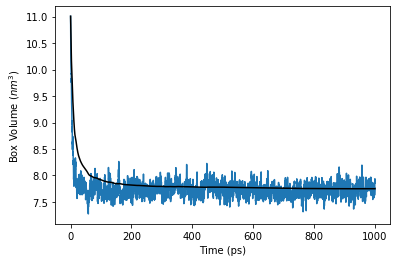

In [31]:
plt.plot(time,V)
plt.xlabel('Time (ps)')
plt.ylabel('Box Volume ($nm^3$)')
total_value = 0
ma_data=[]
for idx,value in enumerate(V):
    total_value += value
    ma_data.append(total_value/(idx+1))

ma_data = np.array(ma_data)
plt.plot(time,ma_data,'black')
print(f"The average volume at convergion is: {ma_data[-1]}")
#cube dimension in Angstrom
cube_dim = ((ma_data[-1]**(1/3))*nanometer/angstrom)
print(f"The box dimensions for a NVT simulation should hence be: {cube_dim}")
plt.show()

In [35]:
from sys import stdout
import time
simulation.reporters.append(CheckpointReporter('checkpnt.chk', 50000))
print("Starting simulation")
start = time.process_time()

simulation.step(total_simulation_steps*2)
end = time.process_time()
print("Elapsed time %.2f seconds" % (end-start))
print("Done!")

simulation.saveCheckpoint('final_state.chk')
simulation.saveState('final_state_output.xml')


Starting simulation
510000,293.8253716822055,7.641860784656743,1.1031099992055358,3136.502031326294
520000,307.22067330184876,7.869629849835665,1.0711829151999506,3152.2321667671204
530000,298.240733350099,7.871353998435036,1.0709482823117231,3167.3430819511414
540000,294.42807923340416,7.612138324885676,1.1074172176473318,3183.56884765625
550000,299.2339843646325,7.898583504796838,1.0672563047503467,3203.678815603256
560000,319.3694910703951,7.850871728662197,1.073742297089851,3220.643186569214
570000,304.37068888569013,7.593070588989013,1.1101981662485654,3236.8358047008514
580000,298.58625482219946,7.561208548345451,1.1148764103241315,3253.2309427261353
590000,269.6895752193385,7.701638627425465,1.0945479854213138,3269.3738367557526
600000,311.8159106606026,7.767666756476657,1.0852439102208864,3284.4518876075745
610000,289.8046222496372,7.92401734614011,1.0638307156404427,3301.033621788025
620000,300.11656100271426,7.86718256505384,1.0715161335567436,3317.4882984161377
630000,295.89

## Catalyst behavior

In [37]:
n_solvent_mol=60
sb_name = f'double_dbu_assisted_benzylaclohol_aCC_{len(solutes)}solutes_N{n_solvent_mol}solvent_box'


#We include 2 DBU molecules to investigate an assisted mechanism
n_molecules = [2,1,1,n_solvent_mol]
if len(n_molecules)!= len(solutes)+len(solvents): raise ValueError('Ascribe a number of molecules for each species')
pdb_filenames = [f"CID_{cid}.pdb" for cid in solutes+solvents]

smiles_codes = [Molecule.from_file(f"CID_{cid}.pdb").to_smiles() for cid in solutes+solvents]
if OpenEyeToolkitWrapper.is_available():
    box_size = packmol.approximate_volume_by_density(smiles_codes,n_molecules)
else:
    box_size = Total_length


# create box with corresponding md_traj trajectory and topology
md_traj_trajectory = packmol.pack_box(pdb_filenames,n_molecules,box_size=box_size)
print(md_traj_trajectory.topology)
md_traj_trajectory.save_pdb(f'{sb_name}_openmoltools.pdb')


# Mixture 

tolerance 2.000000
filetype pdb
output /tmp/tmpr_ipna39/tmplcvhfs86.pdb
add_amber_ter


structure CID_81184.pdb
  number 2 
  inside box 0. 0. 0. 20.608659 20.608659 20.608659
end structure

structure CID_78175.pdb
  number 1 
  inside box 0. 0. 0. 20.608659 20.608659 20.608659
end structure

structure CID_244.pdb
  number 1 
  inside box 0. 0. 0. 20.608659 20.608659 20.608659
end structure

structure CID_679.pdb
  number 60 
  inside box 0. 0. 0. 20.608659 20.608659 20.608659
end structure

<mdtraj.Topology with 64 chains, 64 residues, 687 atoms, 629 bonds>


In [38]:
monomer_names = [f"CID_{cid}.sdf" for cid in solutes+solvents]
pdb_box = PDBFile(f"{sb_name}_openmoltools.pdb")
unique_molecules = [Molecule.from_file(name) for name in monomer_names]
#omm_topology = pdb_box.getTopology()
box_positions = pdb_box.getPositions()
off_box_topology = off.topology.Topology.from_openmm(pdb_box.topology, unique_molecules=unique_molecules)
off_box_system = off_forcefield.create_openmm_system(off_box_topology)

/home/elias/anaconda3/envs/openmm/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (ATOM      2  N   UNL A   1       2.401   9.713  16.403  1.00  0.00           N  , ATOM      1  N   UNL A   1       2.699  11.322  14.645  1.00  0.00           N  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/elias/anaconda3/envs/openmm/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (ATOM      4  C   UNL A   1       4.782  12.384  13.877  1.00  0.00           C  , ATOM      3  C   UNL A   1       3.442  11.777  13.471  1.00  0.00           C  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/elias/anaconda3/envs/openmm/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstr

In [39]:
#Thermostat
integrator = LangevinIntegrator(temperature*kelvin, 1/picosecond, timestep*femtoseconds)
#for isobaric simulation
off_box_system.addForce(MonteCarloBarostat(pressure*bar, temperature*kelvin))  

#setting up the simulation
simulation = Simulation(pdb_box.topology, off_box_system, integrator)
simulation.context.setPositions(box_positions)
simulation.minimizeEnergy()


with open(f"initial_double_DBUassisted_{len(solutes)}solutes_N{n_solvent_mol}solvent_box.pdb", "w") as f:
    PDBFile.writeFile(simulation.topology, pdb_box.positions, f)
    
simulation.reporters = []
simulation.reporters.append(DCDReporter(f'traj__double_DBUassisted_{len(solutes)}solutes_N{n_solvent_mol}solvent.dcd', 100))
simulation.reporters.append(StateDataReporter(stdout, 10000, step=True,
                                              temperature=True,volume=True, density=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter(f"scalars__double_DBUassisted_{len(solutes)}solutes_N{n_solvent_mol}solvent.csv", 100, time=True,
                                              potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, density=True))

simulation.reporters.append(CheckpointReporter('checkpnt_double_DBUassisted_.chk', 50000))
print("Starting simulation")
start = time.process_time()

simulation.step(total_simulation_steps)

end = time.process_time()
print("Elapsed time %.2f seconds" % (end-start))
print("Done!")

simulation.saveCheckpoint('final_state_double_DBUassisted_.chk')
simulation.saveState('final_state_output_double_DBUassisted_.xml')

Starting simulation
#"Step","Temperature (K)","Box Volume (nm^3)","Density (g/mL)","Elapsed Time (s)"
10000,313.0652776502894,8.301008409721456,1.045970450141853,0.00048160552978515625
20000,318.1333665950819,7.887804877875787,1.1007637279797817,17.961888074874878
30000,304.14536336248443,8.112948292202507,1.0702162999476605,34.46234917640686
40000,292.31638105132646,7.772942911647905,1.1170298819429898,50.176666021347046
50000,313.04857487751576,8.001899404194832,1.085068564895477,65.52525997161865
60000,299.21131817491107,7.93893785763995,1.093673947150505,80.4843213558197
70000,286.4307159566199,8.065181298461276,1.0765547830405473,95.6534321308136
80000,297.3834729345895,7.7811633802230835,1.1158497873230275,110.56031656265259
90000,295.6178902596321,8.0081083219749,1.084227279883549,125.60609650611877
100000,315.0193568705144,7.850619551142462,1.1059776169747164,140.47919154167175
110000,295.21236120725246,8.013612403074147,1.0834825876550849,155.67352747917175
120000,313.84293138

## Visualize the output

In [40]:
traj = md.load(f'traj__double_DBUassisted_{len(solutes)}solutes_N{n_solvent_mol}solvent.dcd', top=f"initial_double_DBUassisted_{len(solutes)}solutes_N{n_solvent_mol}solvent_box.pdb")
traj.superpose(traj, 0)
nglview.show_mdtraj(traj)

NGLWidget(count=5000)

## Post-Processing

The average density at convergion is: 1.084052138207537


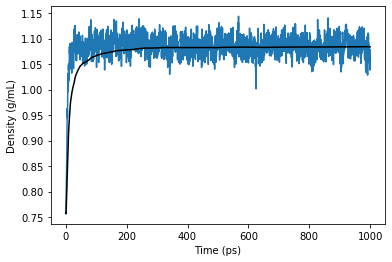

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv(f"scalars__double_DBUassisted_{len(solutes)}solutes_N{n_solvent_mol}solvent.csv")
#print(data.head())
time = data['#"Time (ps)"']
V = data["Box Volume (nm^3)"]
rho = data["Density (g/mL)"]
plt.plot(time,rho)
plt.xlabel('Time (ps)')
plt.ylabel('Density (g/mL)')

total_value = 0
ma_data=[]
for idx,value in enumerate(rho):
    total_value += value
    ma_data.append(total_value/(idx+1))

ma_data = np.array(ma_data)
plt.plot(time,ma_data,'black')

#http://ddbonline.ddbst.de/DIPPR105DensityCalculation/DIPPR105CalculationCGI.exe?component=Acetonitrile
print(f"The average density at convergion is: {ma_data[-1]}")

plt.show()

The average volume at convergion is: 8.014579871024894
The box dimensions for a NVT simulation should hence be: 20.01214251899045


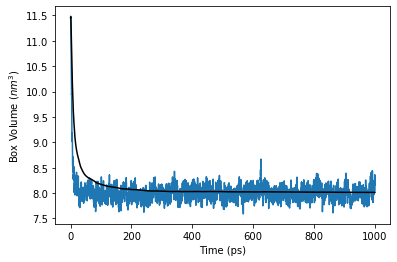

In [43]:
plt.plot(time,V)
plt.xlabel('Time (ps)')
plt.ylabel('Box Volume ($nm^3$)')
total_value = 0
ma_data=[]
for idx,value in enumerate(V):
    total_value += value
    ma_data.append(total_value/(idx+1))

ma_data = np.array(ma_data)
plt.plot(time,ma_data,'black')
print(f"The average volume at convergion is: {ma_data[-1]}")
#cube dimension in Angstrom
cube_dim = ((ma_data[-1]**(1/3))*nanometer/angstrom)
print(f"The box dimensions for a NVT simulation should hence be: {cube_dim}")
plt.show()